---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

A good business strategy for revenue growth is costumer retention. One study has previousley demonstrated that **80%** of a business' future profits will come from ***just* 20%** of the company's existing costumers<sup>[1](#references)</sup>. Also, when comparing to the acquisition of new clients, custumer retention is estimated to be 5-25 times cheaper<sup>[2](#references)</sup>. This where churn and churn rates come in.

<p align=center>
<img src="img/money_loss.jpg" width="50%"><br>
<i><sup>Image credits: upklyak (<a href="https://br.freepik.com/vetores-gratis/queda-da-venda-da-recessao-economica-da-crise-financeira_29942020.htm">www.freepik.com</a>)</sup></i>
</p>

### What is Churn?

Churn represents the number of clients, while the *churn rate* refers to the percentage of users that have been lost to the company over a determined period of time. That is:

**Churn Rate** = $C_B - C_E \over C_B$ $\times 100$, where $C_B$ is the number of customers at the beginning of the period and $C_E$ is the number of customers at the end of the period.

For telecom companies, the churn rate has been estimated at 1.9-2.1% monthly, and 10-67% anually<sup>[3](#references)</sup>. These high churn rates demonstrate why it is important for companies to identify potential *churners* in order to try to prevent this loss of revenue. In this notebook, we will analyse a churn dataset from such a company and employ machine learning strategies to prevent potential churners.

# Getting the data

The data that is used in this project were originally publish as part ot [IBM Developer's learning platform](https://developer.ibm.com/tutorials/watson-studio-using-jupyter-notebook/) and is also available on [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn). It contains information about customers who left within the last month of the analysed period and other customer information (demographics, account information, services that were signed up).

In [99]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Getting the data
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Checking first entries of the dataset
df.head()

# Life, the Universe, and Everything
np.random.seed(42)

## Data variables

As mentioned previously, the dataset contains several columns providing information about the customers:

* `customerID` = Unique ID for each costumer.
* `gender` = The costumers identified gender.
* `SeniorCitizen` = Wether the customer is a senior citizen (1) or not (0).
* `Partner` = Wether the customer has a partner (Yes) or not (No).
* `Dependents` = Whether the customer has dependents (Yes) or not (No).
* `tenure` = Number of months the customer has stayed with the company.
* `PhoneService` = Whether the customer has a phone service (Yes) or not (No).
* `MultipleLines` = Whether the customer has multiple lines (Yes) or not (No *or* No phone service).
* `InternetService` = Customer’s internet service provider (DSL, Fiber optic, No).
* `OnlineSecurity` = Whether the customer has online security (Yes) or not (No *or* No internet service).
* `OnlineBackup` = Whether the customer has online backup (Yes) or not (No *or* No internet service).
* `DeviceProtection` = Whether the customer has device protection (Yes) or not (No *or* No internet service).
* `TechSupport` = Whether the customer has tech support (Yes) or not (No *or* No internet service).
* `StreamingTV` = Whether the customer has streaming TV (Yes) or not (No *or* No internet service).
* `StreamingMovies` = Whether the customer has streaming movies (Yes) or not (No *or* No internet service).
* `Contract` = The contract term of the customer (Month-to-month, One year, Two year).
* `PaperlessBilling` = Whether the customer has paperless billing (Yes) or not (No).
* `PaymentMethod` = The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).
* `MonthlyCharges` = The amount charged to the customer monthly.
* `TotalCharges` = The total amount charged to the customer.
* `Churn` = Whether the customer churned (Yes) or not (No).

## Data Preparation

### Exploratory analysis

First, we will begin by looking at the variables and their characteristics (type, missing values and descriptive statistics).

In [100]:
# Listing data types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [101]:
# Checking null values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [102]:
# Checking unique values
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Here, no columns present null values and `TotalCharges` column is supposed to be float type but is set as object. Also, several columns are binary or with multiple values representing categories that need to be treated as such (need to be encoded). Upon trying to convert `TotalCharges` to numeric:

In [103]:
# Trying to convert column
#df['TotalCharges'].astype('float64')

We face an error:
> `ValueError: could not convert string to float: ''`

This means that instead of null values, the empty values were filled as an empty string, which generates an error. For this reason, we will convert all empty strings to null values and see what we get:

In [104]:
# R7eplacing empty string or records with only spaces with NaN
df_clean = df.replace(r'^\s*$', np.NaN, regex=True)
print('Empty values in "TotalCharges" column: {}'.format(df_clean['TotalCharges'].isnull().sum()))

Empty values in "TotalCharges" column: 11


Since these represent very few empty data points, we are going to replace the missing values with the median from the `TotalCharges` column, which represents a measurement less sensitive to outliers in the data.

In [105]:
# Getting the column median
median_TotalCharges = df_clean.TotalCharges.median()

# Replacing values
df_clean['TotalCharges'].fillna(median_TotalCharges, inplace=True)

# Converting to float
df_clean['TotalCharges'] = df_clean['TotalCharges'].astype('float64')

# Checking empty values again
print('Empty values in "TotalCharges" column: {}'.format(df_clean['TotalCharges'].isnull().sum()))

Empty values in "TotalCharges" column: 0


Now, we describe the numeric columns using descriptive statistics:

In [106]:
# Summary Statistics
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


From this, it appears that the dataset does not contain outliers. Let's check this fact by using boxplots.

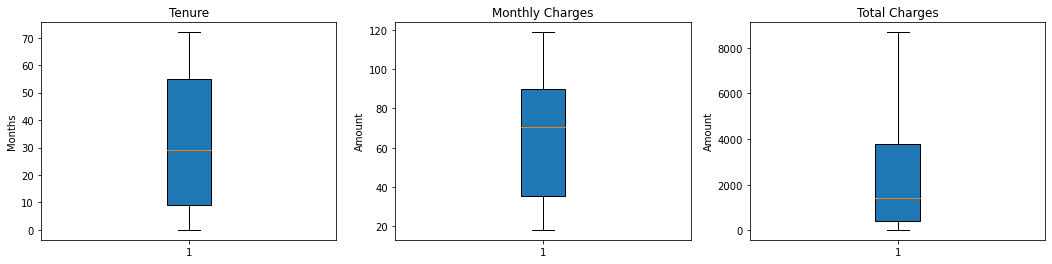

In [107]:
## Creating botplots of numeric data

# Defining suplots
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Creating boxplots in each ax
axs[0].boxplot(df_clean['tenure'], notch=0, vert=1, whis=1.5, patch_artist=True)
axs[1].boxplot(df_clean['MonthlyCharges'], notch=0, vert=1, whis=1.5, patch_artist=True)
axs[2].boxplot(df_clean['TotalCharges'], notch=0, vert=1, whis=1.5, patch_artist=True)

# Adding titles
axs[0].set(title='Tenure', ylabel='Months', xlabel='')
axs[1].set(title='Monthly Charges', ylabel='Amount', xlabel='')
axs[2].set(title='Total Charges', ylabel='Amount', xlabel='');

With these, we confirm that there are no outliers in our data. It does us good to see how our variables are distributed.

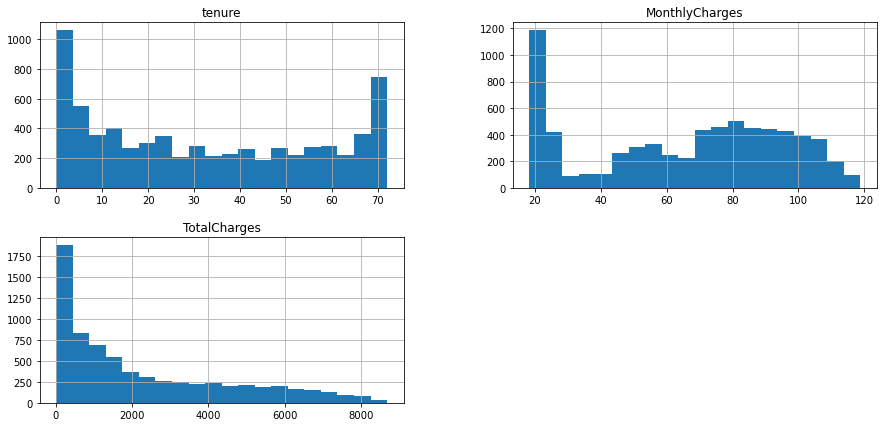

In [108]:
# Histograms of numeric variables
df_clean[['tenure', 'MonthlyCharges', 'TotalCharges']].hist(figsize=(15,7), bins = 20);

Overall, we can see that the distribution of values are skewed towards their ends. The `tenure` variable, representing the months of fidelity with the service, seems to indicate varying degrees of costumer retention, while most of the customers appears to stay for very few months within the service even though we have a high number of costumers staying longer.

`MonthlyCharges` indicate that there are varying degrees of charges, ultimately depending on how many services the client pays for. While those who pay fewer charges seem to dominate the data, the collective number of clients that pays for more services (mostly in the middle range) outnumbers those paying for less services. 

`TotalCharges` on the other hand shows that most charges stay in the lower end of the data range.

Another aspect which is important when dealing with datasets with categorical variables is the number of unique in each column.

In [109]:
# Defining function to print nice table
def uniqueValuesPerColumn(df):
    """
    Takes a dataframe and counts unique values in each
    categorical column of the dataset.
    """
    
    variables = df.select_dtypes('object').columns.to_list()

    unique_values = []

    for variable in variables:
        unique_values.append(', '.join(df[variable].unique()))
    
    unique_df = pd.DataFrame({'Variable': variables,
                              'Unique values': unique_values})
    
    return(unique_df)

In [110]:
# First we drop costumerID column
df_clean.drop("customerID", axis=1, inplace=True)

In [111]:
# Now getting unique values:
pd.option_context('display.max_colwidth', -1)
uniqueValuesPerColumn(df_clean)

,Variable,Unique values
0,gender,"Female, Male"
1,Partner,"Yes, No"
2,Dependents,"No, Yes"
3,PhoneService,"No, Yes"
4,MultipleLines,"No phone service, No, Yes"
5,InternetService,"DSL, Fiber optic, No"
6,OnlineSecurity,"No, Yes, No internet service"
7,OnlineBackup,"Yes, No, No internet service"
8,DeviceProtection,"No, Yes, No internet service"
9,TechSupport,"No, Yes, No internet service"


At first glance, variables which contain `No`, `Yes` and `No internet service` as entries might seem to present an overlap between `No` and `No internet service`. This is untrue. Having one of those entries as `No` means that the costumer might have internet service, while not having the especific additional serviced mentioned in the column. We can check this fact.

In [112]:
# Subsetting only those without internet service
df_noInternet = df_clean[df_clean['InternetService'] == 'No']

# Getting unique values from resulting dataset
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
uniqueValuesPerColumn(df_noInternet[cols])

,Variable,Unique values
0,OnlineSecurity,No internet service
1,OnlineBackup,No internet service
2,DeviceProtection,No internet service
3,TechSupport,No internet service
4,StreamingTV,No internet service
5,StreamingMovies,No internet service


In [113]:
# Subsetting only those with internet service
df_Internet = df_clean[df_clean['InternetService'] != 'No']

# Getting unique values from resulting dataset
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
uniqueValuesPerColumn(df_Internet[cols])

,Variable,Unique values
0,OnlineSecurity,"No, Yes"
1,OnlineBackup,"Yes, No"
2,DeviceProtection,"No, Yes"
3,TechSupport,"No, Yes"
4,StreamingTV,"No, Yes"
5,StreamingMovies,"No, Yes"


With this point proven, we leave these variables intact. Although this represents redundant information, changing these variables to `No` would provide incorrect information to our model.

Another point of interest is class imbalance. In our dataset, classes that might represent a influence in our dataset are the variables `gender` (which might affect some datasets, depending on context, but I do not believe this is the case for our current analysis) and our target variable, `Churn`. Let's check how these are distributed.

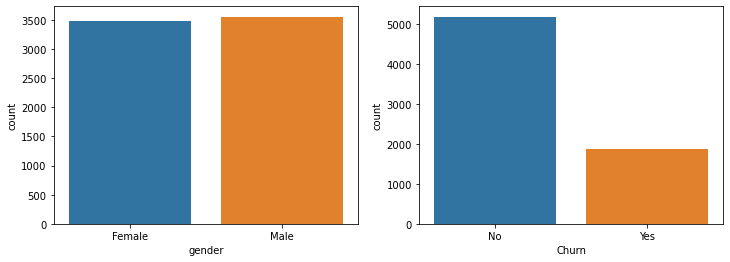

In [114]:
# Defining plots
fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x=df_clean.gender, ax=axs[0])
sns.countplot(x=df_clean.Churn, ax=axs[1]);


With these plots, we can see that `gender` does not represent an imbalance issue, but `Churn` does. Another aspect of our dataset that needs to be addressed is how the variables are coded. Since the categorical variables are strings, we will re-code them in our next session.

### Encoding categorical variables

Now, we recode our variables. Numerical variables will stay the same, while binary variables will be encoded using the `LabelEncoder` approach (including our target variable) and categorical variables with more than two entries will be transformed into dummy variables.

In [115]:
# Creating function to classify columns

def classifyColumns(df):
    """
    Takes a dataframe and returns which columns
    are numeric, binary categories or multiple
    categories, in this order.
    """

    num_cols = df.select_dtypes(['int64', 'float64', 'int32', 'float32']).columns.to_list()
    cat_cols = df.select_dtypes('object').columns.to_list()
    bcat_cols = []
    mcat_cols = []

    for col in cat_cols:
        if len(df[col].unique()) == 2:
            bcat_cols.append(col)
        elif len(df[col].unique()) > 2:
            mcat_cols.append(col)

    return num_cols, bcat_cols, mcat_cols


In [116]:
# Classifying columns with the function
num_cols, bcat_cols, mcat_cols = classifyColumns(df_clean)

# Copying df for backup
df_enc = df_clean.copy()

# Using LabelEncoder to code binary variables
le = LabelEncoder()
for col in bcat_cols:
    df_enc[col] = le.fit_transform(df_enc[col])

# Now getting dummies for categorical variables
df_enc = pd.get_dummies(df_enc, columns=mcat_cols)

# Checking resulting dataframe
df_enc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


## Machine Learning model

Given our data pre-processing, now we can proceed and build our Machine Learning model. At first, in order to assess which classification method would better fit our model at first glance, we will build a baseline comparison where no hyperparameter or feature will be changed.

The data will be split so the test data is isolated from the train/validation data in which we will build and test our models. Since we are using an imbalanced dataset, we use a *stratified sampling* approach when splitting the dataset in order to preserve relative class frequencies. For balancing the dataset, we will use the **Random Under Sampling** (RUS) approach, from the *imbalanced-learn* library, to randomly select samples from the default class. More on RUS can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html).

In [117]:
# Extracting target from dataset
from sklearn.model_selection import train_test_split


X = df_enc.drop('Churn', axis=1)
y = df_enc['Churn']

# Separating train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

# References
1: https://smallbiztrends.com/2016/10/customer-retention-statistics.html

2: https://hbr.org/2014/10/the-value-of-keeping-the-right-customers

3: http://www.dbmarketing.com/telecom/churnreduction.html